Back to the main [Index](index.ipynb)

# Galactose single cell
Single cell model of hepatic galactose clearance.

In [1]:
%matplotlib inline
from __future__ import print_function, division

In [3]:
# simulation & model database
import django
django.setup()
# import the database API functions and tools
import modelmanager.simapp.db.api as db_api
import multiscale.simulate.db.tools as db_tools

In [4]:
# create model in database
import multiscale.examples.testdata as testdata
reload(testdata)

comp_model = db_api.create_model(filepath=testdata.galactose_singlecell_sbml)
if not comp_model:
    # TODO: fix how to get models !
    from simapp.models import CompModel
    comp_models = CompModel.objects.filter(model_id='galactose_29_annotated')
    comp_model = comp_models[0]
print(comp_model)

<SBML: galactose_30_annotated>


## Parameter sensitivity
Analyse the effects of parameter changes on model output with the single-cell galactose model.
### Reference simulation
Reference simulation against which the parameter changes are tested.

In [5]:
import roadrunner
from roadrunner import SelectionRecord
print(roadrunner.getVersionStr())

1.4.2; Compiler: gcc 4.8.4, C++ version: 199711; JIT Compiler: LLVM-3.4; Date: Feb  1 2016, 15:48:52; LibSBML Version: 5.12.0


Time<__init__> SBML compile: 0.311429977417 [s]
['time', '[c__ppi]', '[e__h2oM]', '[c__glc1p]', '[c__udpgal]', '[c__udp]', '[c__atp]', '[c__utp]', '[e__gal]', '[c__gal1pM]', '[c__gal]', '[c__galtolM]', '[e__galM]', '[c__glc6p]', '[c__adp]', '[h__h2oM]', '[c__nadp]', '[c__udpgalM]', '[c__galM]', '[c__galtol]', '[c__nadph]', '[c__glc6pM]', '[c__glc1pM]', '[c__udpglc]', '[c__gal1p]', '[c__udpglcM]', '[c__phos]']
Time<simulate> : 0.00768494606018 [s]


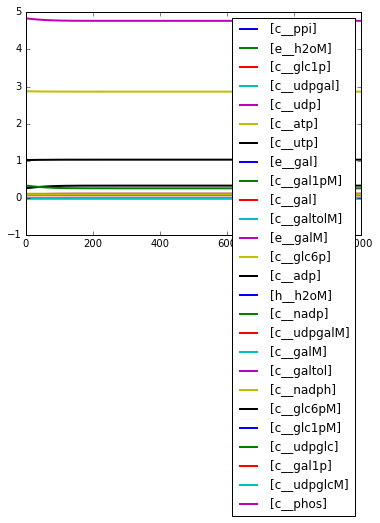

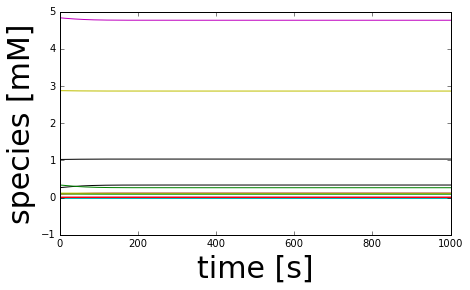

In [12]:
# standard simulation 
import multiscale.simulate.roadrunner_tools as rt
from multiscale.util.timing import time_it

reload(rt)


# load model
r = rt.MyRunner(comp_model.filepath)
# selections
r.selections = ['time'] + ['[{}]'.format(s) for s in r.model.getFloatingSpeciesIds()]
print(r.selections)
# settings
r.set_integrator_settings()
# simulate
s = r.simulate(0, 1000)
r.plot()

r.plot_results([s])

# store final concentrations
c1 = r.store_concentrations()

Time<simulate> : 0.00519180297852 [s]
Time<simulate> : 0.0151219367981 [s]
Time<simulate> : 0.00233483314514 [s]
Time<simulate> : 0.000900030136108 [s]
Time<simulate> : 0.0179090499878 [s]
Time<simulate> : 0.00317215919495 [s]
Time<simulate> : 0.000906944274902 [s]
Time<simulate> : 0.0185029506683 [s]
Time<simulate> : 0.00491213798523 [s]
Time<simulate> : 0.000892877578735 [s]
Time<simulate> : 0.016951084137 [s]
Time<simulate> : 0.00689506530762 [s]
Time<simulate> : 0.00103092193604 [s]
Time<simulate> : 0.0211038589478 [s]
Time<simulate> : 0.00997185707092 [s]
Time<simulate> : 0.000861167907715 [s]
Time<simulate> : 0.0144090652466 [s]
Time<simulate> : 0.0115230083466 [s]
Time<simulate> : 0.000920057296753 [s]
Time<simulate> : 0.0157980918884 [s]
Time<simulate> : 0.0124990940094 [s]
Time<simulate> : 0.000817775726318 [s]
Time<simulate> : 0.0200598239899 [s]
Time<simulate> : 0.013729095459 [s]
Time<simulate> : 0.00110697746277 [s]
Time<simulate> : 0.0172910690308 [s]
Time<simulate> : 0.0

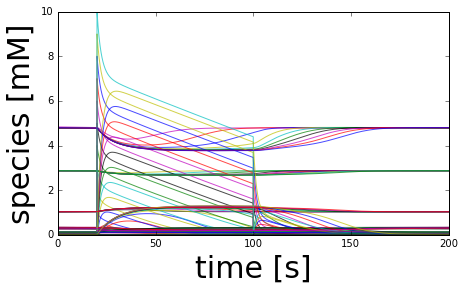

In [15]:
# Galactose challenge after certain amount of time.
# What are the effects of parameter changes in the model (analysis of variability)
# Test galactose challenge

import numpy as np
from roadrunner import SelectionRecord
reload(rt)

# Changed fixed boundary conditions
r.reset(SelectionRecord.ALL)  # reset model

# storage for partial results
results = []
tends = [20, 100, 200]
Nsim = 10

for k in xrange(Nsim):
    # simulate & store concentrations at end point
    s1 = r.simulate(0, tends[0])
    c1 = r.store_concentrations()

    # change boundary concentrations
    e__gal = r.e__gal  # store old value
    r.e__gal = k+1       # set new value
    s2 = r.simulate(tends[0], tends[1])
    
    # reset values
    r.e__gal = e__gal  # restore value
    s3 = r.simulate(tends[1], tends[2])
    
    s = np.concatenate([s1, s2, s3], axis=0)
    results.append(s)

# plot the results
r.plot_results(results, '-', alpha=0.7)

# plot histograms: TODO: how different are the start from the end points

## Test zero concentrations
Check if all external concentrations can be set to zero in the model.

In [22]:
import libsbml
import matplotlib.pylab as plt
doc = libsbml.readSBML(comp_model.filepath)
model = doc.getModel()

# get all external species ids
e_species = []
for s in model.species:
    if (s.compartment == 'e'):
        e_species.append(s)

# set them to zero and simulate
reload(rt)
r = rt.MyRunner(comp_model.filepath)
r.set_integrator_settings()

for e_id in e_species:
    print(e_id)
    s = r.simulate_complex(start=0, end=1000, 
                           concentrations={"init[{}]".format(e_id.id): 0.0})
    r.plot_results([s])
    
r.integrator.setting('variable_step_size')

Time<__init__> SBML compile: 0.312046051025 [s]
<Species e__h2oM "water M*">


AssertionError: 

## Test parameter change
Change all parameters in the model via 10% and see the effect on the model simulations

In [ ]:
# implement the parameter changes
reload(rt)

# TODO: refactor in standard method (standard application of s)
# single parameter variation, double parameter variation, initial concentration variation, initial amount variation.


# All global parameters which are constant have to be varied.
parameter_ids = r.model.getGlobalParameterIds()
import libsbml
doc = libsbml.readSBMLFromFile(comp_model.filepath)
model = doc.getModel()
const_parameter_ids = []
for pid in parameter_ids:
    par = model.getParameter(pid)
    if par.getConstant() == True:
        const_parameter_ids.append(pid)

# number of constant parameters (not calculated via assignment)
print('Number of parameters:', len(const_parameter_ids))

# and this is the amount
factors = [0.9, 1.1]

# repeated simulation
results = []
tends = [20, 50, 70]
gal_ext = [0, 2, 4, 8]

for k_pid, pid in enumerate(sorted(const_parameter_ids)):
    print(k_pid, ':', pid)
    for f in factors:
        for gal in gal_ext:
            # full reset
            r.reset(SelectionRecord.ALL)
            
            # change parameter
            c_backup = rt.store_concentrations(r)
            p_old = r[pid]
            r[pid] = f * p_old
            r.reset(SelectionRecord.INITIAL_GLOBAL_PARAMETER)
            rt.restore_concentrations(r, c_backup)  # restore concentrations
            
            # simulate
           
            s1 = r.simulate(0, tends[0])
            c1 = rt.store_concentrations(r)

            # change boundary concentrations
            e__gal = r.e__gal    # store old value
            r.e__gal = gal       # set new value
            s2 = r.simulate(tends[0], tends[1])

            # reset values
            r.e__gal = e__gal  # restore value
            s3 = r.simulate(tends[1], tends[2])

            s = np.concatenate([s1, s2, s3], axis=0)
            results.append(s)

# plot the results
rt.plot_results(results, '-', color='black', alpha=0.7)

## Double parameter variability

In [ ]:
# get units from the sbml
import libsbml
doc = libsbml.readSBML(comp_model.filepath)
sbml_model = doc.getModel()
units = {}
for pid in const_parameter_ids: 
    p = sbml_model.getParameter(pid)
    unit = p.getUnits()
    units[pid] = unit
units

In [ ]:
# get the original values for all parameters
values = {pid: r[pid] for pid in parameter_ids}

In [ ]:
# now we can setup the single variations
from multiscale.odesim.dist.samples import Sample, SampleParameter
factors = [0.90, 1.10]
samples = []
for pid in parameter_ids:
    for f in factors:
        # create an empty sample
        s = Sample()
        # Set the parameters to the values
        sp = SampleParameter(pid, f * r[pid], unit=units[pid], \
                             parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
        s.add_parameter(sp)
        samples.append(s)

samples

In [ ]:
# We want step based integration in the interval [0.0, 20.0]
settings_dict = {db_api.SettingKey.VAR_STEPS: False,\
                 db_api.SettingKey.T_START: 0.0,\
                 db_api.SettingKey.T_END: 20.0, \
                 db_api.SettingKey.STEPS: 100}

# For the tolerances, ... we use the default settings
settings = db_api.create_settings(settings_dict)
for setting in settings:
    print(setting)

In [ ]:
method = db_api.create_method(method_type=db_api.MethodType.ODE, settings=settings)

In [ ]:
task = db_api.create_task(comp_model, method=method, info="Single parameter variation {}.".format(factors))

In [ ]:
from django.core.exceptions import ValidationError
try:
    # add the simulations to the task
    simulations = db_tools.create_simulations_from_samples(task, samples)
    # finalize task, so no additional simulations can be added
    task.finalize_status()
except ValidationError:
    simulations = task.simulations.all()
simulations
print('TaskStatus:', task.status_str)

In [ ]:
len(simulations)

### Solve the ODE system

Now we are running the solver on the defined problems.

In [ ]:
from multiscale.odesim.simulate import solve

In [ ]:
solve.run_simulations(simulations, task)

In [ ]:
# plot the results
from simapp.models import Result
import matplotlib.pylab as plt
plt_fontsize = 30

In [ ]:
# Load the HDF5 files and plot them
from multiscale.odesim.simulate import solve_io
reload(solve_io)
plt.figure(figsize=(20,14))
for sim in simulations:
    result = Result.objects.get(simulation=sim, result_type=db_api.ResultType.HDF5)
    data, header = solve_io.load_hdf5(result.filepath)
    plt.plot(data[:,0], data[:,1:], '-', color='black')
    
plt.xlabel('time [s]', fontsize=plt_fontsize)
plt.ylabel('species [mM]', fontsize=plt_fontsize);

## Double parameter variation

For comparison all double parameter changes in the model are performed.  
How much larger are the combined effects of parameter changes?

In [ ]:
# now we can setup the double variations
from multiscale.odesim.dist.samples import Sample, SampleParameter
samples_double = []
for pid1 in parameter_ids:
    for pid2 in parameter_ids:
        if pid1 == pid2:
            continue
        for f1 in factors:
            for f2 in factors:
        
                # create an empty sample
                s = Sample()
                # Set first parameter
                sp1 = SampleParameter(pid1, f1 * rr[pid1], unit=units[pid1], \
                             parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
                # Set second parameter
                sp2 = SampleParameter(pid2, f2 * rr[pid2], unit=units[pid2], \
                             parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
                s.add_parameters([sp1, sp2])
                samples_double.append(s)
print('Number of parameters:', len(parameter_ids))                
print('Number of samples:', len(samples_double))

In [ ]:
task_double = db_api.create_task(comp_model, method=method, info="Double parameter variation {}.".format(factors))

In [ ]:
# Removing objects from the database
# from simapp.models import Task
# task_temp = Task.objects.get(pk=64)
# task_temp.delete()
# task_double.info = "Double parameter variation {}.".format(factors)
# task_double.save()

In [ ]:
print('TaskStatus:', task.status_str)
from django.core.exceptions import ValidationError
try:
    # add the simulations to the task
    simulations_double = db_tools.create_simulations_from_samples(task_double, samples_double)
    # finalize task, so no additional simulations can be added
    task_double.finalize_status()
except ValidationError:
    simulations_double = task_double.simulations.all()
simulations
print('TaskStatus:', task.status_str)

In [ ]:
import time
start = time.time()
solve.run_simulations(simulations_double, task_double)
duration = time.time() - start
print('Total time:', duration)

In [ ]:
# Load the HDF5 files and plot them
from multiscale.odesim.simulate import solve_io
reload(solve_io)
plt.figure(figsize=(20,14))
for sim in simulations_double:
    result = Result.objects.get(simulation=sim, result_type=db_api.ResultType.HDF5)
    data, header = solve_io.load_hdf5(result.filepath)
    plt.plot(data[:,0], data[:,1:], '-', color='grey')
    
for sim in simulations:
    result = Result.objects.get(simulation=sim, result_type=db_api.ResultType.HDF5)
    data, header = solve_io.load_hdf5(result.filepath)
    plt.plot(data[:,0], data[:,1:], '-', color='black')
    
plt.xlabel('time [s]', fontsize=plt_fontsize)
plt.ylabel('species [mM]', fontsize=plt_fontsize)